<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/NLP/Trabalhos/T7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!cp -r '/content/drive/MyDrive/full_3/' 'documents'

In [ ]:
!pip install -U keras
!pip install tensorflow

In [34]:
# from tf.keras.layers import Resizing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Leitura dos dados

In [5]:
lista_subfolders = os.listdir('documents')

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
  lista_imagens = os.listdir('documents/'+folder)

  for img_file in lista_imagens:
    dataset_dict['filename'].append(folder+'/'+img_file)
    dataset_dict['label'].append(folder)

In [6]:
df = pd.DataFrame(dataset_dict, columns=['filename', 'label'])

In [7]:
df

,filename,label
0,scientific _publication/2502255678_5684.tif,scientific _publication
1,scientific _publication/10046987_10047002.tif,scientific _publication
2,scientific _publication/2046398702_2046398712.tif,scientific _publication
3,scientific _publication/2505350166.tif,scientific _publication
4,scientific _publication/2505421989.tif,scientific _publication
...,...,...
2956,advertisement/2044905226.tif,advertisement
2957,advertisement/2058504145.tif,advertisement
2958,advertisement/91383464.tif,advertisement
2959,advertisement/6132.tif,advertisement


In [ ]:
# df['label'] = pd.Categorical(df['label'])

In [ ]:
# X = df['filename'].values
# y = df['label'].cat.codes

In [8]:
X = df['filename'].values
y = df['label'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,test_size=0.6, random_state=42)

Criação dos logits dos labels

In [10]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [11]:
lista_train = []

for i in range(0,len(X_train)):
  lista_train.append([X_train[i], y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
  lista_valid.append([X_valid[i], y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
  lista_test.append([X_test[i], y_test[i]])

In [12]:
df_train = pd.DataFrame(lista_train, columns=['filename', 'label'])
df_valid = pd.DataFrame(lista_valid, columns=['filename', 'label'])
df_test = pd.DataFrame(lista_test, columns=['filename', 'label'])

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory='documents',
                                              x_col='filename',
                                              y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory='documents',
                                              x_col='filename',
                                              y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory='documents',
                                              x_col='filename',
                                              y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


In [14]:
test_generator.image_shape

(256, 256, 3)

In [15]:
dims = (224,224,3)
num_classes = 3

In [35]:
model = Sequential()

model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D((3,3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (5,5), strides=(1,1), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(MaxPooling2D((3,3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(384, (3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((3,3), strides=(2,2)))
model.add(Flatten())

model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dense(4096))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 activation_4 (Activation)   (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 26, 26, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)      

In [37]:
sgd = SGD(lr=0.0001)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_generator, 
          epochs=70, 
          batch_size=16, 
          validation_data=valid_generator)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


65/65 [==============================] - 12s 169ms/step - loss: 0.9267 - accuracy: 0.5854 - val_loss: 1.0910 - val_accuracy: 0.3493
Epoch 2/70
65/65 [==============================] - 11s 165ms/step - loss: 0.7461 - accuracy: 0.7698 - val_loss: 1.1031 - val_accuracy: 0.3493
Epoch 3/70
65/65 [==============================] - 11s 176ms/step - loss: 0.6451 - accuracy: 0.8012 - val_loss: 1.1356 - val_accuracy: 0.3493
Epoch 4/70
65/65 [==============================] - 11s 168ms/step - loss: 0.5867 - accuracy: 0.8108 - val_loss: 1.1442 - val_accuracy: 0.3493
Epoch 5/70
65/65 [==============================] - 10s 157ms/step - loss: 0.5433 - accuracy: 0.8214 - val_loss: 1.1162 - val_accuracy: 0.3493
Epoch 6/70
65/65 [==============================] - 10s 157ms/step - loss: 0.5174 - accuracy: 0.8229 - val_loss: 1.0031 - val_accuracy: 0.4479
Epoch 7/70
65/65 [==============================] - 11s 171ms/step - loss: 0.4944 - accuracy: 0.8253 - val_loss: 0.8617 - val_accuracy: 0.5211
Epoch 8/70

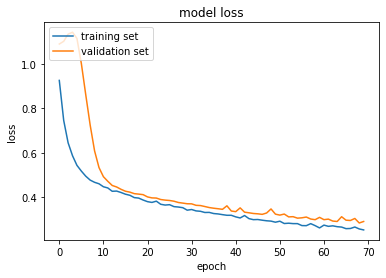

In [38]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [39]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [40]:
y_prob

array([[0.17742153, 0.37363234, 0.44894618],
       [0.9883151 , 0.00470605, 0.00697884],
       [0.03586066, 0.02197297, 0.94216645],
       ...,
       [0.0551803 , 0.02652379, 0.91829586],
       [0.68654287, 0.11795753, 0.19549958],
       [0.28955385, 0.0379662 , 0.67248   ]], dtype=float32)

In [41]:
y_test = test_generator.classes

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.32      0.33       180
           1       0.32      0.32      0.32       170
           2       0.33      0.34      0.34       184

    accuracy                           0.33       534
   macro avg       0.33      0.33      0.33       534
weighted avg       0.33      0.33      0.33       534



In [49]:
model_resnet = Sequential()

model_resnet.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model_resnet.add(ResNet50(include_top = False, weights = None))
model_resnet.add(Dropout(0.5))
model_resnet.add(Flatten())
model_resnet.add(Dense(num_classes))
model_resnet.add(Activation('softmax'))

model_resnet.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 3)                 301059    
                                                                 
 activation_11 (Activation)  (None, 3)                 0         
                                                                 
Total params: 23,888,771
Trainable params: 23,835,651


In [50]:
sgd = SGD(lr=0.0001)

model_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_resnet = model_resnet.fit(train_generator, 
          epochs=70, 
          batch_size=16, 
          validation_data=valid_generator)

Epoch 1/70
65/65 [==============================] - 29s 363ms/step - loss: 1.1925 - accuracy: 0.6134 - val_loss: 1.2151 - val_accuracy: 0.3493
Epoch 2/70
65/65 [==============================] - 23s 354ms/step - loss: 0.9405 - accuracy: 0.7042 - val_loss: 2.0773 - val_accuracy: 0.3493
Epoch 3/70
65/65 [==============================] - 23s 349ms/step - loss: 0.9636 - accuracy: 0.7307 - val_loss: 2.0049 - val_accuracy: 0.3493
Epoch 4/70
65/65 [==============================] - 23s 356ms/step - loss: 0.8428 - accuracy: 0.7534 - val_loss: 1.8977 - val_accuracy: 0.3493
Epoch 5/70
65/65 [==============================] - 23s 347ms/step - loss: 0.8112 - accuracy: 0.7616 - val_loss: 1.6172 - val_accuracy: 0.3662
Epoch 6/70
65/65 [==============================] - 23s 345ms/step - loss: 0.7784 - accuracy: 0.7717 - val_loss: 0.9285 - val_accuracy: 0.6085
Epoch 7/70
65/65 [==============================] - 23s 347ms/step - loss: 0.8218 - accuracy: 0.7606 - val_loss: 0.8344 - val_accuracy: 0.6338

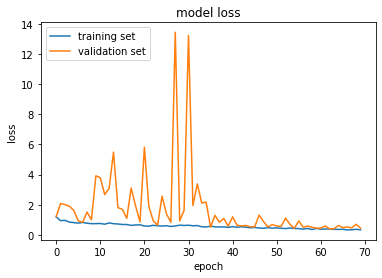

In [53]:
loss = history_fine_resnet.history['loss']
val_loss = history_fine_resnet.history['val_loss']

plt.plot(history_fine_resnet.history['loss'])
plt.plot(history_fine_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)
y_test = test_generator.classes

In [ ]:
print(classification_report(y_test,y_pred))

In [51]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (13.3 MB/s)
debconf: unable to initia

In [55]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [56]:
import pytesseract
try:
    from PIL import Image
except ImportError:
    import Image

In [ ]:
lista_subfolders = os.listdir('documents')

tesseract_dict = {}

tesseract_dict['filename'] = []
tesseract_dict['label'] = []
tesseract_dict['extracted_text'] = []

for folder in lista_subfolders:
  lista_imagens = os.listdir('documents/'+folder)

  i = 0
  for img_file in lista_imagens:
    if i > 100:
      break
    file_path = 'documents/' + str(folder) + '/' + str(img_file)
    tesseract_dict['filename'].append(img_file)
    tesseract_dict['label'].append(folder) 
    extracted = pytesseract.image_to_string(Image.open(file_path))
    tesseract_dict['extracted_text'].append(extracted)
    print(img_file)
    i += 1

2502255678_5684.tif
10046987_10047002.tif
2046398702_2046398712.tif
2505350166.tif
2505421989.tif
1005118878_1005118879.tif
2029135744.tif
2501984338.tif
2505222280_2282.tif
5841.tif
2505104637.tif
00271353_1359.tif
1003932591_2597.tif
2073327385.tif
2024547819_2024547820.tif
10420093.tif
10416983_10416988.tif
1003193821_1003193822.tif
10120754_10120755.tif
2074809052_9064.tif
10416772_10416778.tif
00270787_0792.tif
3382.tif
2022953444_2022953454.tif
6179.tif
10360328_10360345.tif
2022167150_2022167161.tif
10199250_10199256.tif
10335527_10335530.tif
85864368_85864374.tif
2028906178.tif
1386.tif
2072852008.tif
0541.tif
2024957498.tif
85864268_85864272.tif
6733.tif
10346887_10346894.tif
7255.tif
10412566_10412581.tif
2025612553_2561.tif
4434.tif
2024226092_2024226098.tif
1003819910.tif
2505135366_5370.tif
2029241562.tif
2026411695_2026411698.tif
6291.tif
2075584611_4620.tif
7307.tif
11313337.tif
2081783279_3285.tif
88837047_88837052.tif
8485.tif
10342284_10342290.tif
2505269678_9684.tif


In [64]:

tesseract_df = pd.DataFrame(tesseract_dict, columns=['filename', 'label', 'extracted_text'])
tesseract_df

,filename,label,extracted_text
0,2502255678_5684.tif,scientific _publication,"Jets S\n\nBs ra of sean 2.8 08\n\n""Sed tea chi..."
1,10046987_10047002.tif,scientific _publication,\n\nWKBO061175\n\nEEG THETA ACTIVITY AND FAST...
2,2046398702_2046398712.tif,scientific _publication,VALIDITY OF THE SACHS\nOPTIMUM DOSING\nALGORIT...
3,2505350166.tif,scientific _publication,"\n\n \n\n \n\n \n\n \n\n‘horas, 1YTT, 32 155-..."
4,2505421989.tif,scientific _publication,"26/02 ""97 18:38 FAX 41328887776\n\n> SA Neucha..."
...,...,...,...
298,4775.tif,advertisement,pe isle\n\n1 Aq seas $304OWS UIOOY PUB JEL. MO...
299,2084419441_9442.tif,advertisement,\n\nBaHM #342\nBLACK MEN 1/00\n\na aL\naid i ...
300,2026002661.tif,advertisement,"2 Ror. $2 13:28 000 THIELE UA, KOELN TeL 49122..."
301,2080263049.tif,advertisement,\n\n6r0E9z080z\n
